# Loading modules

In [3]:
import xarray as xr
import numpy as np
import sys
from glob import glob
import gc
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import sys
sys.path.append('/home/vmaithel')
"""
local scripts, if loading from a different directory include that with a '.' between
directory name and script name
"""
from tropical_PODs.PODs.POD_utils import limit_files_to_select_years
from tropical_PODs.PODs.POD_utils import calculate_one_variable_binned_ivar_composites
from tropical_PODs.PODs.POD_utils import calculate_two_variable_binned_ivar_composites
from tropical_PODs.PODs.POD_utils import calculate_two_variable_binned_coevolution_composites
from tropical_PODs.PODs.POD_utils import process_multiyear_one_variable_binned_ivar_composites
from tropical_PODs.PODs.POD_utils import process_multiyear_two_variable_binned_ivar_composites
from tropical_PODs.PODs.POD_utils import process_multiyear_two_variable_binned_coevolution_composites
from tropical_PODs.PODs.plotting_utils import plot_one_variable_binned_ivar
from tropical_PODs.PODs.plotting_utils import plot_two_variables_binned_ivar
from tropical_PODs.PODs.POD_utils import numerical_plume_model
from tropical_PODs.PODs.POD_utils import calculate_CAPE

# Define input directories and file names

In [2]:
# Years to analyze
start_year = (2010)
end_year = (2011)

################
###.  ERA5.  ###
################

# Atmosphere

ifile_specific_humidity = '/Projects/era5_regrid/2p5_benedict/ERA5_2.5deg_daily/shum.2p5.*.nc' # ERA5 Specific Humidity
ifile_temperature = '/Projects/era5_regrid/2p5_benedict/ERA5_2.5deg_daily/air.2p5.*.nc' # ERA5 Temperature
ifile_surface_pressure = '/Projects/era5_regrid/2p5_benedict/ERA5_2.5deg_daily/pres.sfc.2p5.*.nc' # ERA5 Surface Pressure
ifile_precipitation = '/Projects/era5_regrid/IMERG/3B-DAY.MS.MRG.3IMERG.V06.*' # IMERG Precipitation

# Land
ifile_land_frac = '../../../tropical_PODs/data/land_sea_mask.erai.2p5.nc' # ERAi Land Fraction 


# Define output directories

In [3]:
# Output directory for datasets
odir_datasets = '../../../tropical_PODs/examples/ofiles_examples/'

# Output directory for datasets
odir_plots = '../../../tropical_PODs/examples/oplots_examples/'

# Driver for calculations

In [4]:
# Define constants
    
g = 9.8 # [m s^-2]

#########################################
# Define paths of files we wish to load #
#########################################
    
# glob expands paths with * to a list of files, like the unix shell #

paths_specific_humidity = glob(ifile_specific_humidity)
paths_temperature = glob(ifile_temperature)
paths_surface_pressure = glob(ifile_surface_pressure)
paths_precipitation = glob(ifile_precipitation)
paths_land = glob(ifile_land_frac)
        
for year in range(start_year, end_year + 1):
        
    print(year)

    # Define year strings #

    previous_year_string = str(year - 1)
    current_year_string = str(year)
    next_year_string = str(year + 1)
            
    while len(previous_year_string) < 4:
        previous_year_string = '0' + previous_year_string
                
    while len(current_year_string) < 4:
        current_year_string = '0' + current_year_string
                
    while len(next_year_string) < 4:
        next_year_string = '0' + next_year_string

    # Limit paths to previous, current, and next year #

    year_limited_paths_specific_humidity = limit_files_to_select_years(paths_specific_humidity, range(year - 1, year + 2))
    year_limited_paths_temperature = limit_files_to_select_years(paths_temperature, range(year - 1, year + 2))
    year_limited_paths_surface_pressure = limit_files_to_select_years(paths_surface_pressure, range(year - 1, year + 2))
    year_limited_paths_precipitation = limit_files_to_select_years(paths_precipitation, range(year - 1, year + 2))

    print(len(year_limited_paths_specific_humidity))
     
    #####################
    ####  Load Data  ####
    #####################

    # Data is "lazy loaded", nothing is actually loaded until we "look" at data in some way #

    dataset_specific_humidity = xr.open_mfdataset(year_limited_paths_specific_humidity, combine="by_coords")
    dataset_temperature = xr.open_mfdataset(year_limited_paths_temperature, combine="by_coords")
    dataset_surface_pressure = xr.open_mfdataset(year_limited_paths_surface_pressure, combine="by_coords")
    dataset_precipitation = xr.open_mfdataset(year_limited_paths_precipitation, combine="by_coords")
    dataset_land = xr.open_dataset(paths_land[0])

    #####################
    ####  Load Data  ####
    #####################
              
    # Make data arrays, loading only the year of interest #
    full_lat = dataset_surface_pressure['lat']
    full_lon = dataset_surface_pressure['lon']
    land_sea_mask = dataset_land['land_sea_mask']

    PS = dataset_surface_pressure['pres'].sel(time = slice(previous_year_string+'-12-31', next_year_string+'-01-01'), lat = slice(10, -10)) # [Pa]
    Q = dataset_specific_humidity['shum'].sel(time = slice(previous_year_string+'-12-31', next_year_string+'-01-01'),lat = slice(10, -10), level = slice(70, 1000)) # [Kg/Kg]
    T = dataset_temperature['air'].sel(time = slice(previous_year_string+'-12-31', next_year_string+'-01-01'),lat = slice(10, -10), level = slice(70, 1000)) # [K]
    precipitation_rate = dataset_precipitation['precipAvg'].sel(time = slice(previous_year_string+'-12-31', next_year_string+'-01-01'), lat = slice(-10, 10)) * (24) # Currently [mm/hr]. Convert to [mm/day]

    # Actually load data #
    land_sea_mask.load()
    PS.load()
    Q.load()
    T.load()
    precipitation_rate.load()

    # Clean up environment #
    
    gc.collect();
 
    ################################
    ####  Average Data to Daily ####
    ################################
    
    ###   Test for Averaging Method   ###
            
    #PS.sel(time=slice('1998-01-01','1998-01-01'),lat=5,lon=75).plot()
    #print(PS.resample(time='1D').mean('time').sel(time=slice('1998-01-01','1998-01-01'),lat=5,lon=75))
    #print(PS.sel(time=slice('1998-01-01','1998-01-01'),lat=5,lon=75).mean('time'))
    #print(PS.resample(time='1D').mean('time').sel(time=slice('1998-01-01','1998-01-01'),lat=5,lon=75).values == PS.sel(time=slice('1998-01-01','1998-01-01'),lat=5,lon=75).mean('time').values)
    
    ###   Perform Averaging   ###
            
    PS = PS.resample(time='1D').mean('time')
    Q = Q.resample(time='1D').mean('time')
    T = T.resample(time='1D').mean('time')
    precipitation_rate = precipitation_rate.resample(time='1D').mean('time')

    precipitation_rate['time'] = precipitation_rate.indexes['time'].to_datetimeindex() # IMERG time was saved as CFtime, and we need to convert to datetime for xarray

    # ### Update time to reflect center of daily average   ###
    
    # PS = PS.assign_coords({'time':PS['time']+pd.to_timedelta(10.5, unit='H')})
    # Q = Q.assign_coords({'time':Q['time']+pd.to_timedelta(10.5, unit='H')})
    # T = T.assign_coords({'time':T['time']+pd.to_timedelta(10.5, unit='H')})


    ###############################################
    ####  Modify "landfrac" Variable as Needed ####
    ###############################################
    
    print("Modifying landfrac as needed")

    landfrac = land_sea_mask.rename({'Latitude':'lat','Longitude':'lon'})
    landfrac = landfrac.rename('landfrac')
    print(landfrac)
    
    # The landfrac variable does not have lat/lon coordinates. Assign those of variables and check to make sure they make sense #
    
    #print(landfrac.coords['lat'])
    landfrac.coords['lat'] = full_lat.coords['lat']
    landfrac.coords['lon'] = full_lon.coords['lon']

    landfrac = landfrac.transpose()

    landfrac = landfrac.sel(lat = slice(10, -10)) 
    
    # Clean up environment #
    
    gc.collect();
    
    #####################################
    ####  Modify variables as needed ####
    #####################################
    
    PS = PS.rename('PS')
    PS = PS.transpose('time','lat','lon')
    PS = PS.sortby('lat', ascending=True) # Re-order lat to match code for other datasets
    #print(PS)
    
    Q = Q.rename({'level':'lev'})
    Q = Q.rename('Q')
    Q = Q.transpose('time','lev','lat','lon')
    Q = Q.sortby('lat', ascending=True) # Re-order lat to match code for other datasets
    #print(Q)
    
    T = T.rename({'level':'lev'})
    T = T.rename('T')
    T = T.transpose('time','lev','lat','lon')
    T = T.sortby('lat', ascending=True) # Re-order lat to match code for other datasets
    #print(T)

    precipitation_rate = precipitation_rate.rename('precipitation_rate')
    precipitation_rate = precipitation_rate.transpose('time','lat','lon')
    precipitation_rate = precipitation_rate.sortby('lat', ascending=True) # Re-order lat to match code for other datasets
    
    landfrac = landfrac.sortby('lat', ascending=True) # Re-order lat to match code for other datasets
    
    # Clean up environment #
    
    gc.collect();

    #########################################
    ####  Calculate True Model Pressure  ####
    #########################################

    print("Calculating true model pressure")
    
    # Set upper most interface equal to uppermost level midpoint, and lowest interface equal to surface pressure.
    # This will still permit the desired vertical integral, just choose appropriate upper and lower integration limits
    
    # Model level midpoint

    true_pressure_midpoint = Q['lev'] * 100. # To convert to Pa
    true_pressure_midpoint = true_pressure_midpoint.rename('true_pressure_midpoint_Pa')
    true_pressure_midpoint = true_pressure_midpoint.expand_dims({'lat':Q['lat'], 'lon':Q['lon'], 'time':Q['time']})
    true_pressure_midpoint = true_pressure_midpoint.transpose('time','lev','lat','lon')
    
    # Model level interfaces
    
    true_pressure_interface = np.empty((len(Q.time),len(Q.lat),len(Q.lon),len(Q.lev)+1))

    for interface_level_counter in range(len(Q.lev) + 1):
        if interface_level_counter == 0:
            true_pressure_interface[:,:,:,interface_level_counter] = Q['lev'].isel(lev=0).values # Set upper most interface equal to uppermost level midpoint
        elif interface_level_counter == (len(Q.lev)):
            true_pressure_interface[:,:,:,interface_level_counter] = PS # Set lowest interface equal to surface pressure
        else:
            true_pressure_interface[:,:,:,interface_level_counter] = (Q['lev'].isel(lev=interface_level_counter-1).values + Q['lev'].isel(lev=interface_level_counter).values) / 2.,  # Set middle interfaces equal to half way points between level midpoints
            
    coords = {'time':Q['time'], 'lat':Q['lat'], 'lon':Q['lon'], 'ilev':np.arange(1,len(Q.lev) + 2)}
    dims = ['time', 'lat', 'lon', 'ilev']
    true_pressure_interface = xr.DataArray(true_pressure_interface,dims=dims,coords=coords) * 100. # To convert to Pa
    true_pressure_interface.attrs['units'] = 'Pa'      
    
    true_pressure_interface = true_pressure_interface.transpose('time','ilev','lat','lon')

    # Clean up environment #
    
    gc.collect();

    ######################################
    ####  Instantiate CAPE Variables  ####
    ######################################
    
    nan_data = np.zeros(np.shape(PS))
    nan_data[:] = np.nan
    coords = PS.coords
    dims = PS.dims
 
    CAPE_DIB_1000_to_600 = xr.DataArray(nan_data,coords=coords,dims=dims)
    CAPE_NOMIX_1000_to_600 = xr.full_like(CAPE_DIB_1000_to_600,np.nan) # can't simply repeat use of nan_data, otherwise pointer indicates same variable
    
    # Name variables #

    CAPE_DIB_1000_to_600.name = 'CAPE_DIB_1000_to_600'
    CAPE_NOMIX_1000_to_600.name = 'CAPE_NOMIX_1000_to_600'
 
    # Add desired attributes #

    CAPE_DIB_1000_to_600.attrs['Units'] = '[J Kg^-1]'
    CAPE_NOMIX_1000_to_600.attrs['Units'] = '[J Kg^-1]'
    
    ####################################
    ####  Calculate Buoyancy Terms  ####
    ####################################
    
    launch_level_hPa = 1000 # [hPa] per Fiaz's code. Must remain close to 1000 to maintain mass flux profile
    
    for latitude in CAPE_DIB_1000_to_600.lat:
        
        print(latitude)
        
        for longitude in CAPE_DIB_1000_to_600.lon:
                            
            ########################################
            ####  Virtual Temperature Variables ####
            ########################################
                
            temp_v_env, temp_v_plume_DIB, temp_v_plume_NOMIX, c_mix_DIB = numerical_plume_model(T.sel(lat=latitude,lon=longitude), Q.sel(lat=latitude,lon=longitude), 1000)

            ##########################
            ####  CAPE Variables  ####
            ##########################
    
            # print('Calculating CAPE Variables')
                
            CAPE_DIB_1000_to_600.loc[dict(lat=latitude,lon=longitude)] = calculate_CAPE(temp_v_env, temp_v_plume_DIB, true_pressure_midpoint.sel(lat=latitude,lon=longitude), true_pressure_interface.sel(lat=latitude,lon=longitude), 100000, 60000)
                
            CAPE_NOMIX_1000_to_600.loc[dict(lat=latitude,lon=longitude)] = calculate_CAPE(temp_v_env, temp_v_plume_NOMIX, true_pressure_midpoint.sel(lat=latitude,lon=longitude), true_pressure_interface.sel(lat=latitude,lon=longitude), 100000, 60000)   
        
            # Clean up environment #
    
            gc.collect();
        
    #################################
    ####  Output Data as NetCDF  ####
    #################################

    # Merge all neccessary dataarrays to a single dataset #

    output_dataset = xr.merge([CAPE_DIB_1000_to_600, CAPE_NOMIX_1000_to_600])

    # Output dataset to NetCDF #

    output_dataset.sel(time = slice(current_year_string+'-01-01', current_year_string+'-12-31')).to_netcdf(odir_datasets + 'CAPE_variables_' + current_year_string + '.nc')
       
    ###############################################
    ####  Limit to Oceanic (<10% Land) Points  ####
    ###############################################
        
    print('Applying Land/Ocean Mask')
        
    # Create ocean mask #

    is_valid_ocean_mask = (landfrac < 0.1)

    #is_valid_ocean_mask.plot()

    # Apply ocean mask to appropriate variables, setting invalid locations to nan #
        
    precipitation_rate = precipitation_rate.where(is_valid_ocean_mask, other = np.nan)

    CAPE_DIB_1000_to_600 = CAPE_DIB_1000_to_600.where(is_valid_ocean_mask, other = np.nan)

    CAPE_NOMIX_1000_to_600 = CAPE_NOMIX_1000_to_600.where(is_valid_ocean_mask, other = np.nan)

    #####################################################################
    ####  Calculate CAPE_DIB_1000_to_600 Single Variable Composites  ####
    #####################################################################
        
    print('Starting CAPE_DIB_1000_to_600 Single Variable Composites')
        
    ### Define binning parameters ###

    ivar = precipitation_rate

    ivar_name_str = 'precipitation_rate'

    ivar_units_str = '[mm day^-1]'
        
    BV1 = CAPE_DIB_1000_to_600
        
    BV1_name_str = 'CAPE_DIB_1000_to_600'
        
    BV1_units_str = '[J Kg^-1]'
        
    lower_BV1_bin_limit_vector = np.arange(-1500, 500, 10) # CAPE_DIB_1000_to_600

    upper_BV1_bin_limit_vector = np.arange(-1500 + 10, 500 + 10, 10) # CAPE_DIB_1000_to_600
        
    log_bins_boolean = False

    fname_datasets = odir_datasets
        
    ##   Precipitation Terms   ###
        
    calculate_one_variable_binned_ivar_composites(ivar, BV1, lower_BV1_bin_limit_vector, upper_BV1_bin_limit_vector, ivar_name_str, ivar_units_str, BV1_name_str, BV1_units_str, year, fname_datasets, log_bins_boolean)

    ###########################################################################
    ###  Calculate CAPE_DIB_1000_to_600 + Linear Precipitation Composites  ####
    ###########################################################################
        
    print('Starting CAPE_DIB_1000_to_600 + Precipitation Composites')
        
    ### Define binning parameters ###

    ivar = precipitation_rate

    ivar_name_str = 'precipitation_rate'

    ivar_units_str = '[mm day^-1]'
        
    BV1 = CAPE_DIB_1000_to_600
        
    BV1_name_str = 'CAPE_DIB_1000_to_600'
        
    BV1_units_str = '[J Kg^-1]'
        
    lower_BV1_bin_limit_vector = np.arange(-1500, 500, 25) # CAPE_DIB_1000_to_600

    upper_BV1_bin_limit_vector = np.arange(-1500 + 25, 500 + 25, 25) # CAPE_DIB_1000_to_600
        
    BV2 = precipitation_rate
        
    BV2_name_str = 'precipitation_rate'
        
    BV2_units_str = '[mm day^-1]'

    lower_BV2_bin_limit_vector = np.concatenate([np.arange(0., 5. + 5., 5.), np.arange(10., 90. + 10., 10.)]) # Precipitation rate

    upper_BV2_bin_limit_vector = np.concatenate([np.arange(5., 10. + 5., 5.), np.arange(20., 100. + 10., 10.)]) # Precipitation rate
        
    log_bins_boolean = False

    fname_datasets = odir_datasets
        
    ###   Precipitation Terms   ###

    calculate_two_variable_binned_coevolution_composites(BV1, BV2, lower_BV1_bin_limit_vector, upper_BV1_bin_limit_vector, lower_BV2_bin_limit_vector, upper_BV2_bin_limit_vector, BV1_name_str, BV1_units_str, BV2_name_str, BV2_units_str, year, fname_datasets, log_bins_boolean)

    calculate_two_variable_binned_ivar_composites(ivar, BV1, BV2, lower_BV1_bin_limit_vector, upper_BV1_bin_limit_vector, lower_BV2_bin_limit_vector, upper_BV2_bin_limit_vector, ivar_name_str, ivar_units_str, BV1_name_str, BV1_units_str, BV2_name_str, BV2_units_str, year, fname_datasets, log_bins_boolean)

    ########################################################################
    ###  Calculate CAPE_DIB_1000_to_600 + Log Precipitation Composites  ####
    ########################################################################
        
    print('Starting CAPE_DIB_1000_to_600 + Log Precipitation Composites')
        
    ### Define binning parameters ###

    log_space = np.logspace(-4,3,num=29)

    ivar = precipitation_rate

    ivar_name_str = 'precipitation_rate'

    ivar_units_str = '[mm day^-1]'
        
    BV1 = CAPE_DIB_1000_to_600
        
    BV1_name_str = 'CAPE_DIB_1000_to_600'
        
    BV1_units_str = '[J Kg^-1]'
        
    lower_BV1_bin_limit_vector = np.arange(-1500, 500, 25) # CAPE_DIB_1000_to_600

    upper_BV1_bin_limit_vector = np.arange(-1500 + 25, 500 + 25, 25) # CAPE_DIB_1000_to_600
        
    BV2 = precipitation_rate
        
    BV2_name_str = 'precipitation_rate'
        
    BV2_units_str = '[mm day^-1]'

    lower_BV2_bin_limit_vector = log_space[0 : -1] # Precipitation rate

    upper_BV2_bin_limit_vector = log_space[1 :] # Precipitation rate
        
    log_bins_boolean = True

    fname_datasets = odir_datasets
        
    ###   Precipitation Terms   ###

    calculate_two_variable_binned_coevolution_composites(BV1, BV2, lower_BV1_bin_limit_vector, upper_BV1_bin_limit_vector, lower_BV2_bin_limit_vector, upper_BV2_bin_limit_vector, BV1_name_str, BV1_units_str, BV2_name_str, BV2_units_str, year, fname_datasets, log_bins_boolean)

    calculate_two_variable_binned_ivar_composites(ivar, BV1, BV2, lower_BV1_bin_limit_vector, upper_BV1_bin_limit_vector, lower_BV2_bin_limit_vector, upper_BV2_bin_limit_vector, ivar_name_str, ivar_units_str, BV1_name_str, BV1_units_str, BV2_name_str, BV2_units_str, year, fname_datasets, log_bins_boolean)

2012
24


/var/folders/1r/wpw0gwg52_j941w9vgbh7k2w0000gn/T/ipykernel_7840/969849937.py:100: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  precipitation_rate['time'] = precipitation_rate.indexes['time'].to_datetimeindex() # IMERG time was saved as CFtime, and we need to convert to datetime for xarray


Modifying landfrac as needed
<xarray.DataArray 'landfrac' (lon: 144, lat: 73)>
array([[nan,  0.,  0., ...,  1.,  1., nan],
       [nan,  0.,  0., ...,  1.,  1., nan],
       [nan,  0.,  0., ...,  1.,  1., nan],
       ...,
       [nan,  0.,  0., ...,  1.,  1., nan],
       [nan,  0.,  0., ...,  1.,  1., nan],
       [nan,  0.,  0., ...,  1.,  1., nan]])
Dimensions without coordinates: lon, lat
Calculating true model pressure
<xarray.DataArray 'lat' ()>
array(-10., dtype=float32)
Coordinates:
    lat      float32 -10.0
Attributes:
    long_name:  latitude
    units:      degrees_north
<xarray.DataArray 'lat' ()>
array(-7.5, dtype=float32)
Coordinates:
    lat      float32 -7.5
Attributes:
    long_name:  latitude
    units:      degrees_north
<xarray.DataArray 'lat' ()>
array(-5., dtype=float32)
Coordinates:
    lat      float32 -5.0
Attributes:
    long_name:  latitude
    units:      degrees_north
<xarray.DataArray 'lat' ()>
array(-2.5, dtype=float32)
Coordinates:
    lat      float32

# Driver for plotting

In [5]:
# Define colormap # 

colors = [(10, 50, 120), (15, 75, 165), (30, 110, 200), (60, 160, 240), (80, 180, 250), (130, 210, 255), (160, 240, 255), (200, 250, 255), (230, 255, 255), (230, 230, 230), (230, 230, 230), (255, 250, 220), (255, 232, 120), (255, 192, 60), (255, 160, 0), (255, 96, 0), (255, 50, 0), (225, 20, 0), (192, 0, 0), (165, 0, 0)]
for list_index in range(len(colors)):
    colors[list_index] = tuple(tuple_element/255. for tuple_element in colors[list_index])
        
n_bin = 200
cmap_name = 'colors'
colormap_colors = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bin)

### Define plotting parameters ###

min_number_of_obs = 200

years_to_plot_list = list(range(2010,2012))

## Load and plot CAPE_DIB_1000_to_600 binned data

In [6]:

###   Precipitation Rate   ###

precipitation_rate_composite = process_multiyear_one_variable_binned_ivar_composites(limit_files_to_select_years(glob(odir_datasets + 'CAPE_DIB_1000_to_600_binned_precipitation_rate_composite_*'), years_to_plot_list))



#### CAPE_DIB_1000_to_600 Binned Precipitation Rate with PDF

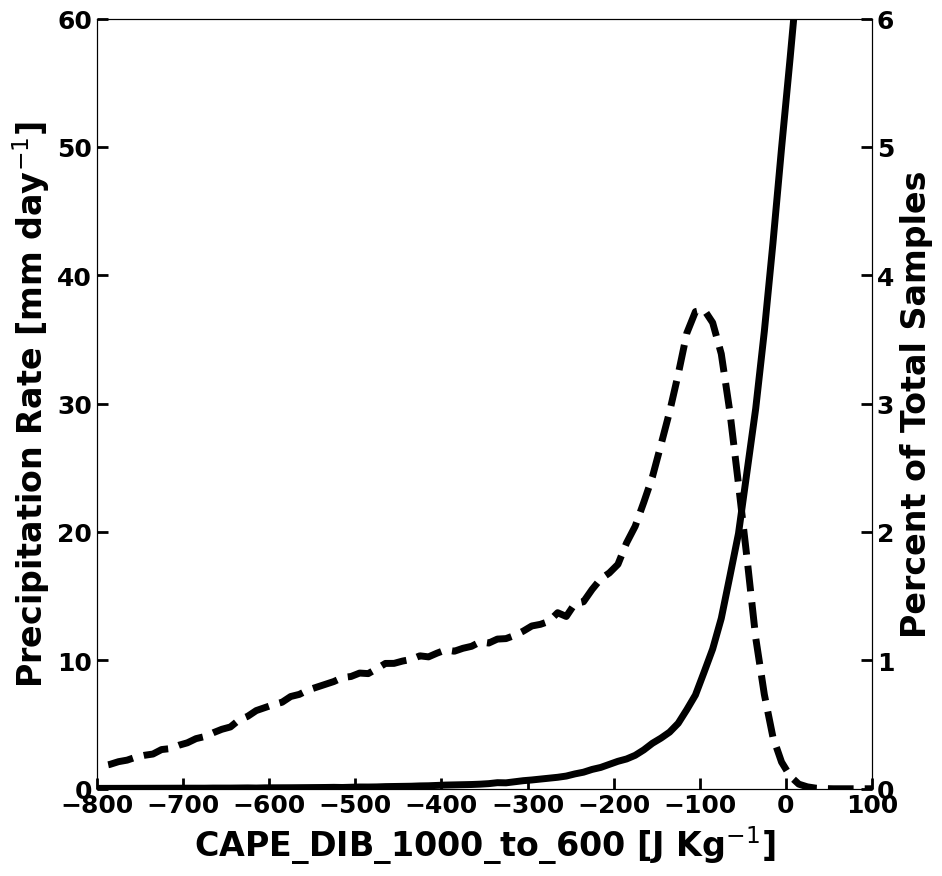

In [7]:
x_axis_limits = (-800, 100)
y_axis_limits = (0, 60)
pdf_axis_limits = (0, 6)
x_axis_label = 'CAPE_DIB_1000_to_600 [J Kg$^{-1}$]'
y_axis_label = 'Precipitation Rate [mm day$^{-1}$]'
pdf_axis_label='Percent of Total Samples'
log_X_axis_boolean = False
log_Y_axis_boolean = False
plot_pdf_boolean = True
save_fig_boolean = False
figure_path_and_name = odir_plots + 'CAPE_DIB_1000_to_600_binned_precipitation_rate_' + str(years_to_plot_list[0]) + '_' + str(years_to_plot_list[-1]) + '.png'

plot_one_variable_binned_ivar(precipitation_rate_composite, min_number_of_obs, x_axis_limits, y_axis_limits, pdf_axis_limits, x_axis_label, y_axis_label, pdf_axis_label, log_X_axis_boolean, log_Y_axis_boolean, plot_pdf_boolean, save_fig_boolean, figure_path_and_name)

#### CAPE_DIB_1000_to_600 Binned Precipitation Rate with PDF on Log Scale

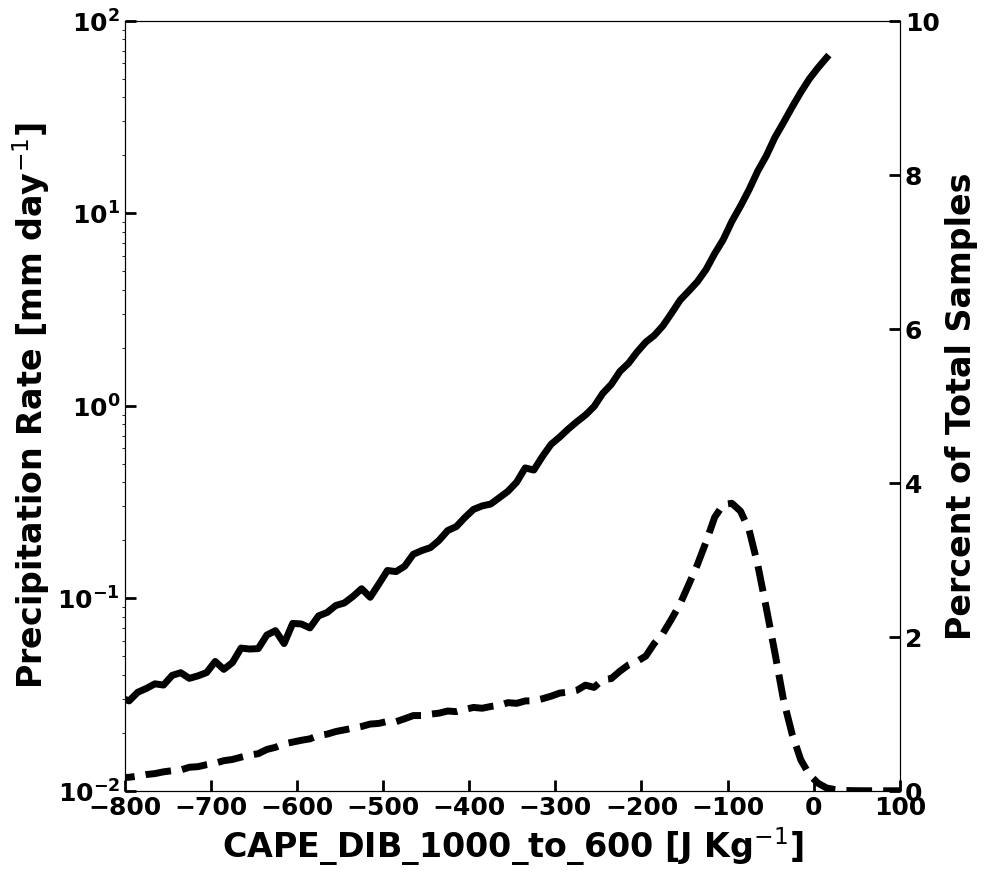

In [8]:
x_axis_limits = (-800, 100)
y_axis_limits = (10**-2, 10**2)
pdf_axis_limits = (0, 10)
x_axis_label = 'CAPE_DIB_1000_to_600 [J Kg$^{-1}$]'
y_axis_label = 'Precipitation Rate [mm day$^{-1}$]'
pdf_axis_label='Percent of Total Samples'
log_X_axis_boolean = False
log_Y_axis_boolean = True
plot_pdf_boolean = True
save_fig_boolean = False
figure_path_and_name = odir_plots + 'CAPE_DIB_1000_to_600_binned_log_precipitation_rate_' + str(years_to_plot_list[0]) + '_' + str(years_to_plot_list[-1]) + '.png'

plot_one_variable_binned_ivar(precipitation_rate_composite, min_number_of_obs, x_axis_limits, y_axis_limits, pdf_axis_limits, x_axis_label, y_axis_label, pdf_axis_label, log_X_axis_boolean, log_Y_axis_boolean, plot_pdf_boolean, save_fig_boolean, figure_path_and_name)

## Load and plot CAPE_DIB_1000_to_600-precipitation binned data

In [10]:
CAPE_DIB_1000_to_600_precipitation_rate_binned_coevolution_composite = process_multiyear_two_variable_binned_coevolution_composites(limit_files_to_select_years(glob(odir_datasets + 'CAPE_DIB_1000_to_600_precipitation_rate_binned_coevolution_composite_*'), years_to_plot_list))
CAPE_DIB_1000_to_600_precipitation_rate_binned_precipitation_rate_composite = process_multiyear_two_variable_binned_ivar_composites(limit_files_to_select_years(glob(odir_datasets + 'CAPE_DIB_1000_to_600_precipitation_rate_binned_precipitation_rate_composite_*'), years_to_plot_list))

#### Probability of increasing precipitation rate

/Users/bwolding_personal/anaconda3/lib/python3.11/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


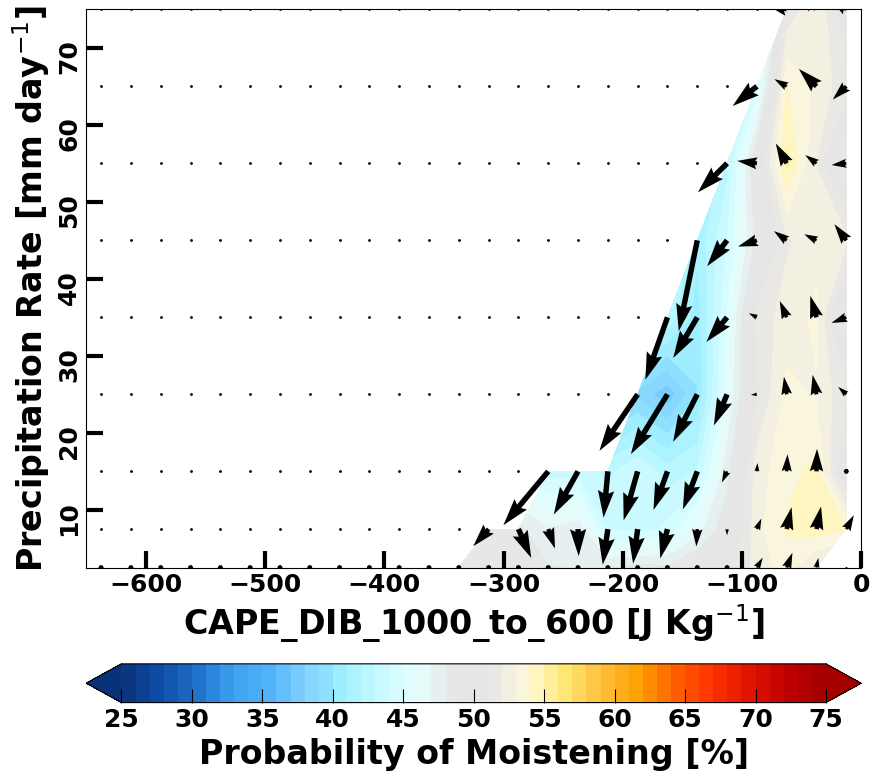

In [11]:
two_variable_binned_coevolution_composites = CAPE_DIB_1000_to_600_precipitation_rate_binned_coevolution_composite
x_axis_limits = (-650, 0)
y_axis_limits = (two_variable_binned_coevolution_composites['bin_number_of_samples_centered'].BV2_bin_midpoint.min(), 75)
x_axis_label = 'CAPE_DIB_1000_to_600 [J Kg$^{-1}$]'
y_axis_label = 'Precipitation Rate [mm day$^{-1}$]'
pdf_axis_label='Percent of Total Samples'
log_Y_axis_boolean = False
color_shading_var = (CAPE_DIB_1000_to_600_precipitation_rate_binned_precipitation_rate_composite['bin_number_pos_delta_ivar_centered'] / CAPE_DIB_1000_to_600_precipitation_rate_binned_precipitation_rate_composite['bin_number_of_samples_centered'])*100
color_shading_var_number_of_samples = CAPE_DIB_1000_to_600_precipitation_rate_binned_precipitation_rate_composite['bin_number_of_samples_centered']
color_shading_levels = np.arange(25, 76, 1)
color_shading_map = colormap_colors
colorbar_extend_string = 'both'
colorbar_tick_levels = np.arange(25, 80, 5)
colorbar_label_string = 'Probability of Moistening [%]'
scientific_colorbar_boolean = False
plot_vectors_boolean = True
leading_lagging_centered_string='centered'
save_fig_boolean = False
figure_path_and_name = odir_plots + 'CAPE_DIB_1000_to_600_precipitation_rate_binned_precipitation_rate_composite_' + str(years_to_plot_list[0]) + '_' + str(years_to_plot_list[-1]) + '.png'

plot_two_variables_binned_ivar(two_variable_binned_coevolution_composites, color_shading_var, color_shading_var_number_of_samples, min_number_of_obs, color_shading_levels, color_shading_map, colorbar_extend_string, colorbar_tick_levels, colorbar_label_string, scientific_colorbar_boolean, log_Y_axis_boolean, x_axis_limits, y_axis_limits, x_axis_label, y_axis_label, plot_vectors_boolean, leading_lagging_centered_string, save_fig_boolean, figure_path_and_name)


## Load and plot log binbed CAPE_DIB_1000_to_600-precipitation binned data

In [12]:
CAPE_DIB_1000_to_600_precipitation_rate_log_binned_coevolution_composite = process_multiyear_two_variable_binned_coevolution_composites(limit_files_to_select_years(glob(odir_datasets + 'CAPE_DIB_1000_to_600_precipitation_rate_log_binned_coevolution_composite_*'), years_to_plot_list))
CAPE_DIB_1000_to_600_precipitation_rate_log_binned_precipitation_rate_composite = process_multiyear_two_variable_binned_ivar_composites(limit_files_to_select_years(glob(odir_datasets + 'CAPE_DIB_1000_to_600_precipitation_rate_log_binned_precipitation_rate_composite_*'), years_to_plot_list))

/Users/bwolding_personal/anaconda3/lib/python3.11/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


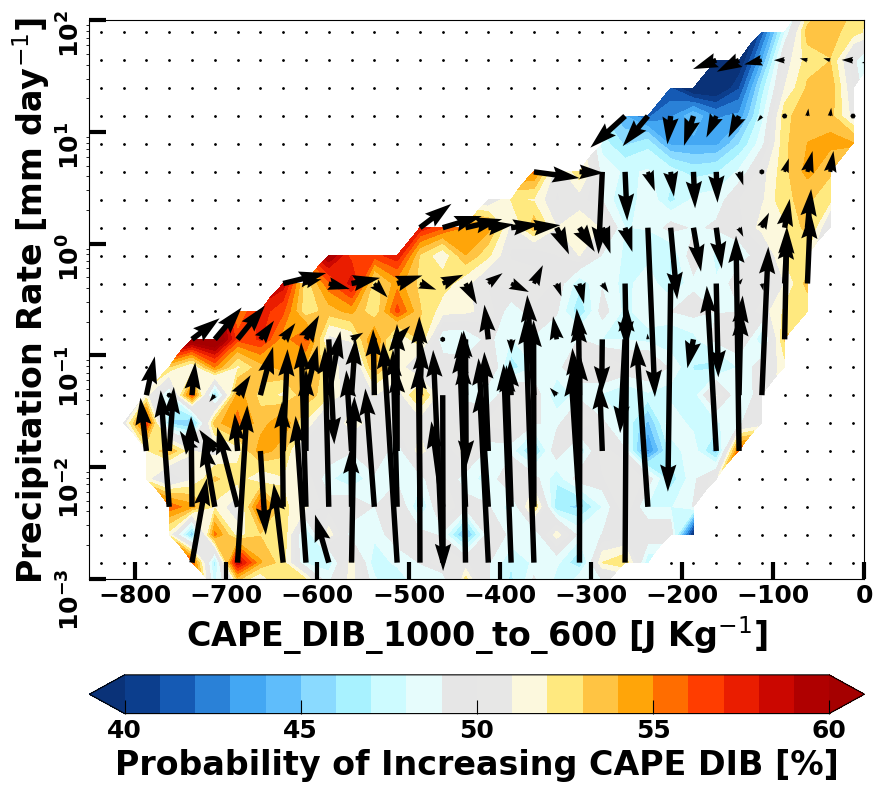

In [14]:
two_variable_binned_coevolution_composites = CAPE_DIB_1000_to_600_precipitation_rate_log_binned_coevolution_composite
x_axis_limits = (-850, 0)
y_axis_limits = (10**-3, 10**2)
x_axis_label = 'CAPE_DIB_1000_to_600 [J Kg$^{-1}$]'
y_axis_label = 'Precipitation Rate [mm day$^{-1}$]'
pdf_axis_label='Percent of Total Samples'
log_Y_axis_boolean = True
color_shading_var = (CAPE_DIB_1000_to_600_precipitation_rate_log_binned_precipitation_rate_composite['bin_number_pos_delta_ivar_centered'] / CAPE_DIB_1000_to_600_precipitation_rate_log_binned_precipitation_rate_composite['bin_number_of_samples_centered'])*100
color_shading_var_number_of_samples = CAPE_DIB_1000_to_600_precipitation_rate_log_binned_precipitation_rate_composite['bin_number_of_samples_centered']
color_shading_levels = np.arange(40, 61, 1)
color_shading_map = colormap_colors
colorbar_extend_string = 'both'
colorbar_tick_levels = np.arange(40, 65, 5)
colorbar_label_string = 'Probability of Increasing CAPE DIB [%]'
scientific_colorbar_boolean = False
plot_vectors_boolean = True
leading_lagging_centered_string='centered'
save_fig_boolean = False
figure_path_and_name = odir_plots + 'CAPE_DIB_1000_to_600_precipitation_rate_log_binned_precipitation_rate_composite_' + str(years_to_plot_list[0]) + '_' + str(years_to_plot_list[-1]) + '.png'

plot_two_variables_binned_ivar(two_variable_binned_coevolution_composites, color_shading_var, color_shading_var_number_of_samples, min_number_of_obs, color_shading_levels, color_shading_map, colorbar_extend_string, colorbar_tick_levels, colorbar_label_string, scientific_colorbar_boolean, log_Y_axis_boolean, x_axis_limits, y_axis_limits, x_axis_label, y_axis_label, plot_vectors_boolean, leading_lagging_centered_string, save_fig_boolean, figure_path_and_name)
